**Imports and creating dataset**

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from typing import List, Dict, Tuple, Callable
from copy import deepcopy
import copy

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/MyDrive/Daria Gudemchuk - intel_places_ds.zip (Unzipped Files)'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, "seg_" + x + "/seg_" + x ),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


**Creating and training models**

In [14]:
vgg16 = models.vgg16(pretrained=True)
vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
for param in vgg16.parameters():    
  param.requires_grad = False

In [16]:
vgg16.classifier[6] = nn.Linear(4096, len(class_names))
vgg16.classifier.add_module('7', nn.LogSoftmax(dim=1))
if torch.cuda.is_available():
    vgg16.cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(vgg16.parameters())

In [17]:
summary(vgg16, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters())

In [27]:
from copy import deepcopy
train_loader = dataloaders['train']

def train_and_check(model, loss_func, optim, epochs=15):
  '''
  Function to train and check results
  Parameters:
    :param model: model to train
    :param loss_func: loss function
    :param optim: optimizer for gradients
    :param epochs: number of epochs to train (default=15)
  Returns:
    model(last model): trained model with best accuracy
    history: list containing avg train loss and accuracy
  '''
  model.train()
  history = []
  for epoch in range(epochs):
    last_model = deepcopy(model)
    print(f"Epoch {epoch + 1}/{epochs}")


    train_loss = 0.
    for i, (inputs, labels) in enumerate(train_loader):
      if i % 50 == 0:
        print(i)

      inputs, labels = inputs.to('cuda:0'), labels.to('cuda:0')

      optim.zero_grad()
      outputs = model(inputs)
      loss = loss_func(outputs, labels)
      loss.backward()
      optim.step()
      train_loss += loss.item() * inputs.size(0)
    avg_train_loss = train_loss / len(image_datasets['train']) 
    print(avg_train_loss)
    history.append(avg_train_loss)
    if epoch >= 1:
      if avg_train_loss > history[-2]:
        return last_model, history
    
  return model, history

In [29]:
trained_model = train_and_check(vgg16, loss_fn, optimizer, 5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
50
100
150
200
0.39988715571013034
Epoch 2/5
0
50
100
150
200
0.37796362758838026
Epoch 3/5
0
50
100
150
200
0.38192939032885836


In [31]:
trained_vgg16 = trained_model[0].to('cuda:0')

In [32]:
def predict(model, dataloader):
  all_preds = torch.tensor([]).to('cuda:0')
  true_vals = torch.tensor([]).to('cuda:0')
  with torch.no_grad():
    model.eval()
    for (X, y) in dataloader:
      X, y = X.to('cuda:0'), y.to('cuda:0')
      all_preds = torch.cat((all_preds, model(X)), 0)
      true_vals = torch.cat((true_vals, y), 0)
  return all_preds, true_vals

In [35]:
outputs, labels = predict(trained_vgg16, dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [50]:
mobile_net = models.mobilenet_v2(pretrained=True)

for param in mobile_net.parameters():
  param.requires_grad = False

mobile_net.classifier[1] = nn.Linear(1280, len(class_names))
mobile_net.classifier.add_module('2', nn.LogSoftmax(dim=1))

mobile_net.to('cuda:0')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [51]:
summary(mobile_net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [54]:
mobile_loss_fn = nn.CrossEntropyLoss()
mobile_optimizer = optim.Adam(mobile_net.parameters())
trained_mobile_net = train_and_check(mobile_net, mobile_loss_fn, mobile_optimizer, 5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
50
100
150
200
0.4086714841014506
Epoch 2/5
0
50
100
150
200
0.3950365521518087
Epoch 3/5
0
50
100
150
200
0.3982536677614617


In [55]:
trained_mobile_net, mobile_net_history = trained_mobile_net
trained_mobile_net.to('cuda:0')

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [56]:
mob_outputs, mob_labels = predict(trained_mobile_net, dataloaders['test'])
#outputs = outputs.to('cuda:0')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Classification report and ROC curves for models**

In [58]:
print('Classification report for VGG model\n\n')
_, outs = torch.max(outputs, dim=1)
print(classification_report(labels.cpu().numpy(), outs.cpu().numpy(), target_names=class_names))
print('Confusion matrix for VGG model\n\n')
print(confusion_matrix(labels.cpu().numpy(), outs.cpu().numpy(), normalize='true'))

Classification report for VGG model


              precision    recall  f1-score   support

   buildings       0.95      0.86      0.90       437
      forest       0.99      1.00      0.99       474
     glacier       0.86      0.87      0.86       553
    mountain       0.88      0.83      0.86       525
         sea       0.94      0.98      0.96       510
      street       0.88      0.96      0.92       501

    accuracy                           0.91      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.91      0.91      0.91      3000

Confusion matrix for VGG model


[[0.85812357 0.         0.         0.00228833 0.00228833 0.13729977]
 [0.         0.99578059 0.         0.0021097  0.         0.0021097 ]
 [0.         0.00180832 0.86618445 0.09222423 0.03616637 0.00361664]
 [0.00190476 0.00190476 0.1447619  0.83238095 0.01714286 0.00190476]
 [0.00196078 0.00196078 0.00588235 0.00784314 0.98235294 0.        ]
 [0.03393214 0.00199601 0.00199601 0.0019

In [59]:
def plot_roc_curves(fpr_tpr, roc_auc):
  colors = ['blue', 'yellow', 'green', 'pink', 'orange', 'black']
  plt.title('Receiver Operating Characteristic')
  for i in range(6):
    plt.plot(fpr_tpr[i][0], fpr_tpr[i][1], colors[i], label = 'ROC curve for class %i AUC = %0.2f' %(i, roc_auc[i]))
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

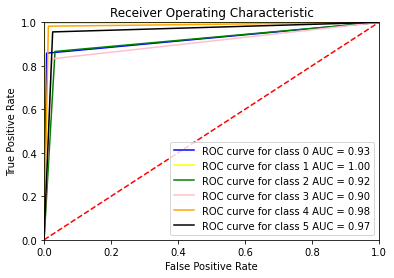

In [60]:
labels_plot = [(labels.cpu().numpy() == i).astype(float) for i in range(6)]
outs_plot = [(outs.cpu().numpy() == i).astype(float) for i in range(6)]

fpr_tpr = [roc_curve(labels_plot[i], outs_plot[i]) for i in range(6)]
roc_auc = [auc(fpr_tpr[i][0], fpr_tpr[i][1]) for i in range(6)]

plot_roc_curves(fpr_tpr, roc_auc)

In [61]:
print('Classification report for MobileNet model\n\n')
_, mob_outs = torch.max(mob_outputs, dim=1)
print(classification_report(mob_labels.cpu().numpy(), mob_outs.cpu().numpy(), target_names=class_names))
print('Confusion matrix for VGG model\n\n')
print(confusion_matrix(mob_labels.cpu().numpy(), mob_outs.cpu().numpy(), normalize='true'))

Classification report for MobileNet model


              precision    recall  f1-score   support

   buildings       0.92      0.87      0.89       437
      forest       0.99      0.99      0.99       474
     glacier       0.91      0.80      0.85       553
    mountain       0.84      0.88      0.86       525
         sea       0.90      0.98      0.94       510
      street       0.89      0.93      0.91       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000

Confusion matrix for VGG model


[[0.86956522 0.00457666 0.         0.00228833 0.00915332 0.11441648]
 [0.         0.98945148 0.         0.00421941 0.00421941 0.0021097 ]
 [0.00361664 0.00180832 0.79927667 0.14104882 0.04882459 0.00542495]
 [0.         0.00571429 0.07238095 0.87619048 0.04380952 0.00190476]
 [0.00392157 0.         0.00588235 0.00784314 0.98039216 0.00196078]
 [0.05788423 0.         0.00199601 

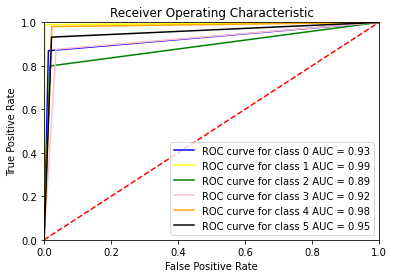

In [62]:
mob_labels_plot = [(mob_labels.cpu().numpy() == i).astype(float) for i in range(6)]
mob_outs_plot = [(mob_outs.cpu().numpy() == i).astype(float) for i in range(6)]

fpr_tpr = [roc_curve(mob_labels_plot[i], mob_outs_plot[i]) for i in range(6)]
roc_auc = [auc(fpr_tpr[i][0], fpr_tpr[i][1]) for i in range(6)]

plot_roc_curves(fpr_tpr, roc_auc)

**Visualizing model predictions**

In [63]:
X, y = next(iter(dataloaders['test']))
X = X.to('cuda:0')
probas = trained_model[0](X)
_, preds = torch.max(probas, dim=1)

def show(images, labels, predicts):
  fig = plt.figure(figsize=(16,12), dpi=1600)
  axes = []
  k = 0
  for i in range(3):
    for j in range(4):
      axes.append(plt.subplot2grid((3, 4), (i, j)))
      inp = images[k]
      inp = inp.numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      axes[k].set_ylabel(labels[k])
      axes[k].set_xlabel(predicts[k])
      axes[k].set_xticks([])
      axes[k].set_yticks([])
      plt.imshow(inp)
      k += 1
  plt.show()
y = [class_names[x] for x in y[:12]]
preds = [class_names[x] for x in preds[:12]]
show(X.to('cpu')[:12], y, preds)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
